The significant aspects and concepts involved in LangGraph:

* **StateGraph:** This is the core class you instantiate to define the structure of your chatbot as a graph of states and transitions. It manages the nodes and edges.
* **Graph Traversal:** This refers to the process of moving through the nodes of the graph based on the defined edges and conditions during a conversation.
* **Configuration:** When running the graph, you'll often provide configuration settings, such as the initial state and input.
* **Input:** The initial data provided to the LangGraph to start a conversation turn (often the user's first message).
* **Output:** The final state or a specific part of the state that represents the chatbot's response or the outcome of the conversation turn.
* **Callbacks:** Since LangGraph often integrates with LangChain, callback handlers can be used to monitor and interact with different stages of the graph execution (e.g., logging, tracing).
* **Runnables:** Nodes in LangGraph can often leverage LangChain's `Runnable` interface, allowing for composable sequences of operations within a node.
* **Tools:** LangGraph facilitates the integration of LangChain's tools, which allow the chatbot to interact with the outside world.
* **Memory:** While the `State` in LangGraph manages the current turn's information, integrating LangChain's memory components can enable the chatbot to retain information across multiple turns.



In [3]:
%%capture --no-stderr
%pip install -U langgraph langsmith
%pip install langgraph langchain google-generativeai
%pip install langchain_google_genai

# https://aistudio.google.com/apikey - Gemini API Key

In [4]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("GOOGLE_API_KEY")

GOOGLE_API_KEY: ··········


We will start by building a basic LangGraph chatbot using a StateGraph with nodes for the LLM and functions, and edges to define the conversational flow, resulting in a rudimentary working chatbot.

# **StateGraph**

In [17]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [18]:
import google.generativeai as genai
import os
from langchain_google_genai import ChatGoogleGenerativeAI

genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

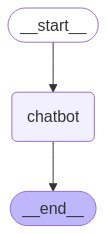

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In this image representing a simple LangGraph, we can identify the following:

1. **Nodes**: The labeled shapes represent nodes. Here, we have three nodes:

        __start__: This is a special starting node, indicating where the conversation begins.

        chatbot: This node represents the core logic of the chatbot, where user input is processed (e.g., by an LLM or a function).

        __end__: This is a special ending node, indicating where the conversation concludes for a particular turn or flow.

2. **Edges:** The arrows connecting the nodes represent edges. They define the flow of the conversation:

        There is a directed edge going from the __start__ node to the chatbot node, meaning after the start, the process moves to the chatbot logic.
        
        There is another directed edge going from the chatbot node to the __end__ node, meaning after the chatbot processing, the flow reaches the end.

3. **State**: While the image doesn't explicitly show the state, it's implicitly managed as the conversation moves through these nodes.
        
        The chatbot node would receive the current state (which might include the user's message and any previous context), process it, and potentially update the state before the flow reaches the __end__ node.
        
        The state is the information that persists and evolves as the conversation moves through the nodes connected by the edges.

In [20]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: Hi, how are you?
Assistant: I'm doing well, thank you for asking!  How are you today?
User: Do you know who is the President of US?
Assistant: The current President of the United States is Joe Biden.
User: My name is Subham
Assistant: It's nice to meet you, Subham!
User: Do you know my name?
Assistant: No, I do not know your name.  I have no memory of past conversations.  Each interaction with me starts fresh.
User: What do you know about LangGraph?
Assistant: LangGraph is a relatively new and evolving project focused on creating large language models (LLMs) that are more **explainable and interpretable** than traditional black-box models.  It differs from many other LLMs by emphasizing the creation of a **knowledge graph** alongside the language model itself.

Here's what we know about its key aspects:

* **Knowledge Graph Integration:**  The core innovation is the tight integration of a knowledge graph.  This graph represents factual knowledge and relationships between entities

## https://tavily.com/ - Tavily API

In [9]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [10]:
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


# **Tools**

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [ ]:
tool.invoke("What's a 'node' in LangGraph?")

**The results are page summaries our chat bot can use to answer questions.**

In [12]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)



import google.generativeai as genai
import os
from langchain_google_genai import ChatGoogleGenerativeAI

genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

llm_with_tools = llm.bind_tools(tools)



def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [13]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

After adding the tool node, we'll define conditional_edges using a route_tools function. This function will examine the chatbot's output for tool calls and direct the flow to the tools node if present, or to the END node otherwise, using add_conditional_edges.

In [14]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

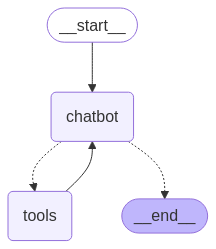

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: What do you know about LangGraph?
Assistant: 
Assistant: [{"title": "LangGraph Quickstart - GitHub Pages", "url": "https://langchain-ai.github.io/langgraph/tutorials/introduction/", "content": "[](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-9-1)Assistant: LangGraph is a library designed to help build stateful multi-agent applications using language models. It provides tools for creating workflows and state machines to coordinate multiple AI agents or language model interactions. LangGraph is built on top of LangChain, leveraging its components while adding graph-based coordination capabilities. It's particularly useful for developing more complex, [...] [](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-21-6)   LangGraph is a library designed for building stateful, multi-actor applications with Large Language Models (LLMs). It's particularly useful for creating agent and multi-agent workflows.\n[](https://langchain-a

# **Memory**

In [21]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [22]:
from typing import Annotated


import google.generativeai as genai
import os
from langchain_google_genai import ChatGoogleGenerativeAI

genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))


from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [23]:
graph = graph_builder.compile(checkpointer=memory)

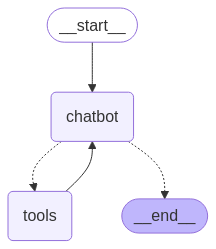

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [25]:
config = {"configurable": {"thread_id": "1"}}

In [29]:
while True:
    user_input = input("Enter your message (or 'q' or 'quit' to exit): ")
    if user_input.lower() in ['q', 'quit']:
        print("Exiting...")
        break

    events = graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config,
        stream_mode="values",
    )
    for event in events:
        event["messages"][-1].pretty_print()

Enter your message (or 'q' or 'quit' to exit): Hi, how are you? My name is Subham
================================ Human Message =================================

Hi, how are you? My name is Subham
================================== Ai Message ==================================

Hello Subham, I am doing well, thank you for asking. How can I help you today?
Enter your message (or 'q' or 'quit' to exit): Do you remember my name?
================================ Human Message =================================

Do you remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Subham.
Enter your message (or 'q' or 'quit' to exit): q
Exiting...


In [32]:
while True:
    user_input = input("Enter your message (or 'q' or 'quit' to exit): ")
    if user_input.lower() in ['q', 'quit']:
        print("Exiting...")
        break

    events = graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        {"configurable": {"thread_id": "2"}},
        stream_mode="values",
    )
    for event in events:
        event["messages"][-1].pretty_print()

Enter your message (or 'q' or 'quit' to exit): Remember my name?
================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I am sorry, I cannot remember your name. I have no memory of past conversations.
Enter your message (or 'q' or 'quit' to exit): q
Exiting...


In [35]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi, my name is Subham', additional_kwargs={}, response_metadata={}, id='3b8f8332-75aa-47c1-949b-bbcf8f881933'), HumanMessage(content='What do you know about LangGraph?', additional_kwargs={}, response_metadata={}, id='ba28c156-f4da-4a4b-9da3-c6e1a76bd7d0'), HumanMessage(content='Hi, my name is Subham', additional_kwargs={}, response_metadata={}, id='d9cf8e6a-d485-4ad0-972a-6a18c00f774f'), HumanMessage(content='What do you know about LangGraph?', additional_kwargs={}, response_metadata={}, id='4b0a8bed-1663-47e4-9d2d-548ee96dc5ae'), HumanMessage(content='My name is Subham', additional_kwargs={}, response_metadata={}, id='3d4e9f42-763f-4e3b-a66f-a3434d77e684'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "LangGraph"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash

# **Human-in-the-loop**

**LangGraph's persistence layer enables human-in-the-loop workflows by allowing execution to pause and resume based on user feedback. The interrupt function is the main tool for this, pausing execution when called within a node. Resumption occurs with new input from a human via a Command. Notably, interrupt is designed to feel similar to Python's standard input() function.**

In [36]:
from typing import Annotated

import google.generativeai as genai
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [37]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

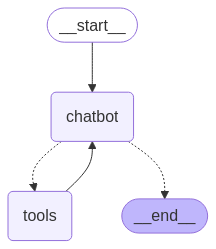

In [38]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [39]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (59442e9b-605f-4672-b572-2fcaaf27f57e)
 Call ID: 59442e9b-605f-4672-b572-2fcaaf27f57e
  Args:
    query: I need expert guidance for building an AI agent.


In [40]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

**If we have a human response that is already stored in db or a person who can take the call, the input can be integrated as follows**

In [41]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (59442e9b-605f-4672-b572-2fcaaf27f57e)
 Call ID: 59442e9b-605f-4672-b572-2fcaaf27f57e
  Args:
    query: I need expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts recommend checking out LangGraph to build your agent. They say it's more reliable and extensible than simple autonomous agents.
